In [1]:
!nvidia-smi

Wed Jul 12 04:34:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:E3:00.0 Off |                    0 |
| N/A   35C    P0    53W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pickle
from pathlib import Path
from functools import partial

import torch

from mdmm_ml import MDMMMLModule
from gnn_tracking.training.callbacks import PrintValidationMetrics
from gnn_tracking.models.graph_construction import GraphConstructionFCNN
from gnn_tracking.metrics.losses import GraphConstructionHingeEmbeddingLoss

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.utils.dictionaries import to_floats

from torch_geometric.data import Data
from torch import nn
from pytorch_lightning.core.mixins import HyperparametersMixin

import pandas as pd

In [3]:
val_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9")
assert val_dir.is_dir()

In [4]:
train_dirs = []
train_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/")
for i in range(1,9):
    d = os.path.join(train_dir, f"part_{i}")
    if os.path.isdir(d):
        train_dirs.append(d)

In [5]:
train_dirs

['/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_2',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_3',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_4',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_5',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_6',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_7',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8']

In [6]:
dm = TrackingDataModule(
    train=dict(
        dirs=train_dirs,
        batch_size=4
    ),
    val=dict(
        dirs=[val_dir],
        stop=500,
    ),
    # could also configure a 'test' set here
)

In [7]:
# This is called by the Trainer automatically and sets up the datasets
dm.setup(stage="fit")  # 'fit' combines 'train' and 'val'
# Now the datasets are available:
dm.datasets

[04:34:51] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[04:34:51] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8/data28999_s0.pt
[04:34:51] INFO: DataLoader will load 500 graphs (out of 1000 available).
[04:34:51] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29499_s0.pt


{'train': TrackingDataset(7743), 'val': TrackingDataset(500)}

In [8]:
class CollectLossHistory(Callback):
    def __init__(self):
        self.data_list = []

    def on_validation_epoch_end(self, trainer, *args):
        if not trainer.sanity_checking:
            self.data_list.append(to_floats(trainer.callback_metrics))

    def get_history(self):
        return pd.DataFrame.from_records(self.data_list)

In [9]:
from torch.optim.lr_scheduler import StepLR

In [10]:
import matplotlib.pyplot as plt

In [11]:
import collections
from torch import Tensor
from gnn_tracking.utils.dictionaries import add_key_suffix

In [13]:
def train_model_mdmm(main_losses,
                     constraint_losses,
                     dm,
                     max_epochs=50
                    ):
    
    model = GraphConstructionFCNN(in_dim=14, out_dim=10, depth=5, hidden_dim=64)

    lmodel = MDMMMLModule_2(
        model=model,
        loss_fct=GraphConstructionHingeEmbeddingLoss(),
        main_losses = main_losses,
        constraint_losses = constraint_losses,
        optimizer=partial(torch.optim.Adam),
        scheduler=partial(StepLR, step_size=4, gamma=0.75),
        lr_params=0.02,
        lr_lambda=-0.02
    )
    
    loss_history_cb = CollectLossHistory()

    trainer = Trainer(max_epochs=max_epochs, accelerator="gpu",
                     log_every_n_steps=1, callbacks=[loss_history_cb, PrintValidationMetrics(),
                                                     TQDMProgressBar(refresh_rate=5)])
    trainer.fit(model=lmodel, datamodule=dm)

    loss_history = loss_history_cb.get_history()
    train_loss_history = lmodel.get_train_history()
    return train_loss_history, loss_history

In [14]:
train_loss_history, loss_history = train_model_mdmm(main_losses={"attractive":1.0},
                                   constraint_losses={
                                            "repulsive": {"weight":1.0,
                                                          "epsilon":0.0025,
                                                          "damping_factor":10.0}},
                                   dm=dm,
                                   max_epochs=24)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:35:15] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[04:35:15] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8/data28999_s0.pt
[04:35:15] INFO: DataLoader will load 500 graphs (out of 1000 available).
[04:35:15] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


        Validation epoch=1        
┏━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric     ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive │ 0.03525 │ 0.00026 │
│ repulsive  │ 0.05807 │ 0.00163 │
│ total      │ 0.05070 │ 0.00117 │
└────────────┴─────────┴─────────┘



/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

        Validation epoch=1        
┏━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric     ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive │ 0.00296 │ 0.00001 │
│ repulsive  │ 0.00221 │ 0.00001 │
│ total      │ 0.00287 │ 0.00001 │
└────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00240 │ 0.00000 │
│ attractive_train │ 0.00398 │     nan │
│ repulsive        │ 0.00303 │ 0.00001 │
│ repulsive_train  │ 0.00268 │     nan │
│ total            │ 0.00253 │ 0.00001 │
│ total_train      │ 0.00403 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00238 │ 0.00000 │
│ attractive_train │ 0.00257 │     nan │
│ repulsive        │ 0.00258 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00240 │ 0.00000 │
│ total_train      │ 0.00257 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00181 │ 0.00000 │
│ attractive_train │ 0.00214 │     nan │
│ repulsive        │ 0.00228 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00176 │ 0.00000 │
│ total_train      │ 0.00214 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00174 │ 0.00000 │
│ attractive_train │ 0.00195 │     nan │
│ repulsive        │ 0.00223 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00168 │ 0.00000 │
│ total_train      │ 0.00194 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00165 │ 0.00000 │
│ attractive_train │ 0.00175 │     nan │
│ repulsive        │ 0.00227 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00160 │ 0.00000 │
│ total_train      │ 0.00175 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00161 │ 0.00000 │
│ attractive_train │ 0.00169 │     nan │
│ repulsive        │ 0.00231 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00157 │ 0.00000 │
│ total_train      │ 0.00169 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00143 │ 0.00000 │
│ attractive_train │ 0.00165 │     nan │
│ repulsive        │ 0.00272 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00148 │ 0.00000 │
│ total_train      │ 0.00165 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00146 │ 0.00000 │
│ attractive_train │ 0.00161 │     nan │
│ repulsive        │ 0.00245 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00145 │ 0.00000 │
│ total_train      │ 0.00161 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00145 │ 0.00000 │
│ attractive_train │ 0.00150 │     nan │
│ repulsive        │ 0.00220 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00139 │ 0.00000 │
│ total_train      │ 0.00150 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00150 │ 0.00000 │
│ attractive_train │ 0.00149 │     nan │
│ repulsive        │ 0.00205 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00140 │ 0.00000 │
│ total_train      │ 0.00149 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00139 │ 0.00000 │
│ attractive_train │ 0.00146 │     nan │
│ repulsive        │ 0.00241 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00137 │ 0.00000 │
│ total_train      │ 0.00146 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00131 │ 0.00000 │
│ attractive_train │ 0.00146 │     nan │
│ repulsive        │ 0.00284 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00138 │ 0.00000 │
│ total_train      │ 0.00146 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00136 │ 0.00000 │
│ attractive_train │ 0.00136 │     nan │
│ repulsive        │ 0.00229 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00132 │ 0.00000 │
│ total_train      │ 0.00136 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00136 │ 0.00000 │
│ attractive_train │ 0.00136 │     nan │
│ repulsive        │ 0.00215 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00129 │ 0.00000 │
│ total_train      │ 0.00136 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00135 │ 0.00000 │
│ attractive_train │ 0.00135 │     nan │
│ repulsive        │ 0.00233 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00132 │ 0.00000 │
│ total_train      │ 0.00135 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00128 │ 0.00000 │
│ attractive_train │ 0.00135 │     nan │
│ repulsive        │ 0.00234 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00125 │ 0.00000 │
│ total_train      │ 0.00135 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00122 │ 0.00000 │
│ attractive_train │ 0.00128 │     nan │
│ repulsive        │ 0.00275 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00126 │ 0.00000 │
│ total_train      │ 0.00128 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00000 │
│ attractive_train │ 0.00128 │     nan │
│ repulsive        │ 0.00228 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00123 │ 0.00000 │
│ total_train      │ 0.00128 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00000 │
│ attractive_train │ 0.00128 │     nan │
│ repulsive        │ 0.00273 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00124 │ 0.00000 │
│ total_train      │ 0.00128 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=21           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00123 │ 0.00000 │
│ attractive_train │ 0.00127 │     nan │
│ repulsive        │ 0.00241 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00121 │ 0.00000 │
│ total_train      │ 0.00127 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=22           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00000 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00236 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00124 │ 0.00000 │
│ total_train      │ 0.00123 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=23           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00125 │ 0.00000 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00262 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00127 │ 0.00000 │
│ total_train      │ 0.00123 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.


          Validation epoch=24           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00000 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00224 │ 0.00001 │
│ repulsive_train  │ 0.00250 │     nan │
│ total            │ 0.00122 │ 0.00000 │
│ total_train      │ 0.00123 │     nan │
└──────────────────┴─────────┴─────────┘



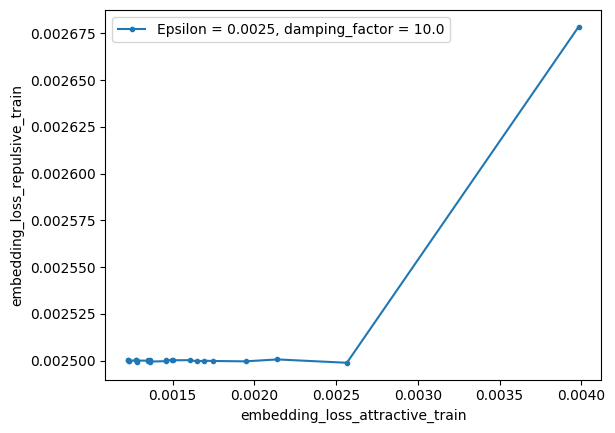

In [15]:
label = f'Epsilon = {0.0025}, damping_factor = {10.0}'
train_loss_history.plot(x='attractive_train', y='repulsive_train', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')

plt.legend()
plt.show()

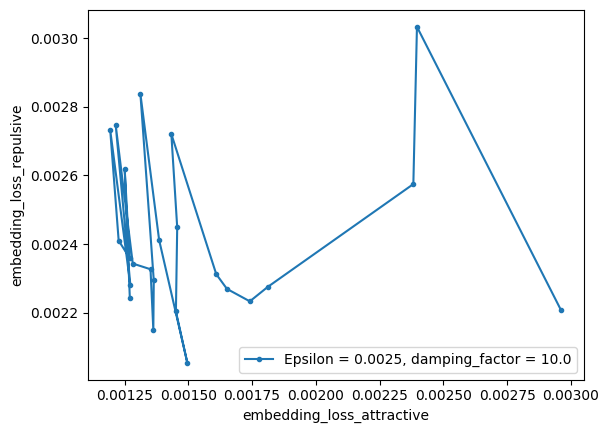

In [16]:
label = f'Epsilon = {0.0025}, damping_factor = {10.0}'
loss_history.plot(x='attractive', y='repulsive', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')

plt.legend()
plt.show()

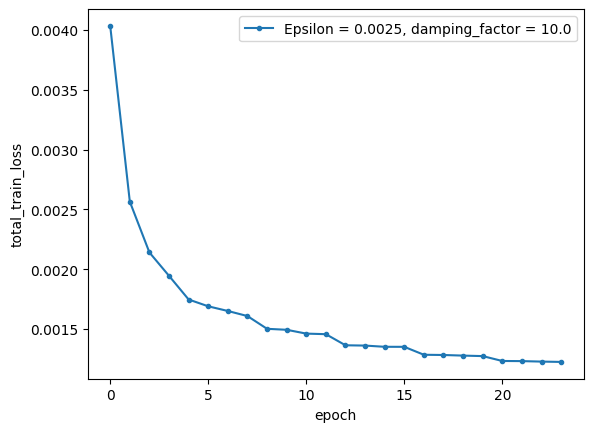

In [17]:
label = f'Epsilon = {0.0025}, damping_factor = {10.0}'
train_loss_history.plot(y='total_train', use_index=True, marker='o', markersize=3, label=label)

plt.xlabel('epoch')
plt.ylabel('total_train_loss')

plt.legend()
plt.show()

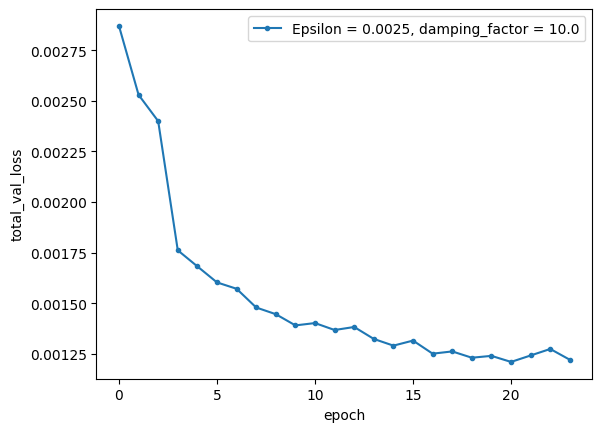

In [18]:
label = f'Epsilon = {0.0025}, damping_factor = {10.0}'
loss_history.plot(y='total', use_index=True, marker='o', markersize=3, label=label)

plt.xlabel('epoch')
plt.ylabel('total_val_loss')

plt.legend()
plt.show()

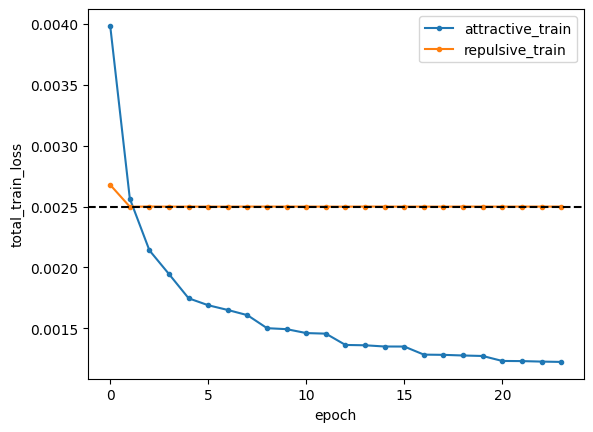

In [21]:
train_loss_history.plot(y=['attractive_train','repulsive_train'], use_index=True, marker='o', markersize=3)

plt.xlabel('epoch')
plt.ylabel('total_train_loss')
plt.axhline(0.0025, linestyle='--', color='black')

plt.legend()
plt.show()

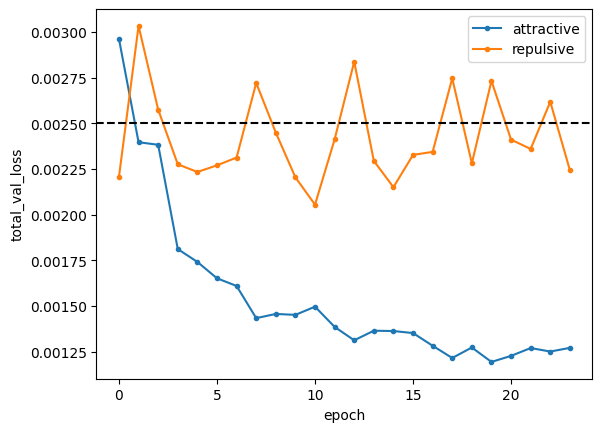

In [22]:
loss_history.plot(y=['attractive','repulsive'], use_index=True, marker='o', markersize=3)

plt.xlabel('epoch')
plt.ylabel('total_val_loss')
plt.axhline(0.0025, linestyle='--', color='black')

plt.legend()
plt.show()

In [23]:
loss_history.to_csv('loss_history.csv')

In [24]:
train_loss_history.to_csv('train_loss_history.csv')

In [10]:
def save_loss_history(loss_hparams_list, path):
    if not os.path.exists(path):
        os.makedirs(path)
    
    for i, loss_hparams in enumerate(loss_hparams_list):
        print(f'Training for case = {i}')

        main_losses = loss_hparams["main_losses"]
        constraint_losses = loss_hparams["constraint_losses"]

        loss_history = train_model_mdmm(main_losses=main_losses,
                                        constraint_losses=constraint_losses,
                                        dm=dm,
                                        max_epochs=20)
        
        model_dict = {'loss_history':loss_history,
                      'main_losses':main_losses,
                      'constraint_losses':constraint_losses}
        
        file_path = os.path.join(path, f'case_{i}.pkl')

        with open(file_path, "wb") as f:
            pickle.dump(model_dict,f)
            f.close()
        print("\n")

In [11]:
def save(main_loss, constraint_loss, epsilons, damping_factor, path):
    loss_hparams_list = []

    for epsilon in epsilons:
        loss_hparams = {"main_losses":{main_loss:1.0},
                        "constraint_losses":{
                            constraint_loss: {"weight":1.0,
                                              "epsilon":epsilon,
                                              "damping_factor":damping_factor}
                            }
                        }
        loss_hparams_list.append(loss_hparams)

    save_loss_history(loss_hparams_list, path)

In [12]:
epsilons = [0.0011069910833612084,
            0.0007505328394472599,
            0.00041287270141765475,
            0.0002665876236278564,
            0.00013125120312906802]

In [13]:
save(main_loss="attractive",
     constraint_loss="repulsive",
     epsilons=epsilons,
     damping_factor=1.0, path="loss_histories/damping_1")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:10:25] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:10:25] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:10:25] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:10:25] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_conden

Training for case = 0


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/dc3896/notebooks/lightning_logs/version_49016548/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphConstructionFCNN               | 17.9 K
1 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00178 │ 0.00001 │
│ attractive_train │ 0.00186 │     nan │
│ repulsive        │ 0.00099 │ 0.00002 │
│ repulsive_train  │ 0.00070 │     nan │
│ total            │ 0.00170 │ 0.00001 │
│ total_train      │ 0.00160 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00147 │ 0.00001 │
│ attractive_train │ 0.00152 │     nan │
│ repulsive        │ 0.00112 │ 0.00002 │
│ repulsive_train  │ 0.00081 │     nan │
│ total            │ 0.00147 │ 0.00001 │
│ total_train      │ 0.00136 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00124 │ 0.00001 │
│ attractive_train │ 0.00116 │     nan │
│ repulsive        │ 0.00115 │ 0.00002 │
│ repulsive_train  │ 0.00108 │     nan │
│ total            │ 0.00126 │ 0.00001 │
│ total_train      │ 0.00115 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00113 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00107 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00112 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00098 │ 0.00000 │
│ attractive_train │ 0.00108 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00102 │     nan │
│ total            │ 0.00097 │ 0.00001 │
│ total_train      │ 0.00104 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00104 │ 0.00000 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00104 │ 0.00002 │
│ repulsive_train  │ 0.00097 │     nan │
│ total            │ 0.00102 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00087 │ 0.00000 │
│ attractive_train │ 0.00092 │     nan │
│ repulsive        │ 0.00110 │ 0.00002 │
│ repulsive_train  │ 0.00100 │     nan │
│ total            │ 0.00086 │ 0.00001 │
│ total_train      │ 0.00089 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00092 │ 0.00000 │
│ attractive_train │ 0.00093 │     nan │
│ repulsive        │ 0.00104 │ 0.00002 │
│ repulsive_train  │ 0.00102 │     nan │
│ total            │ 0.00090 │ 0.00001 │
│ total_train      │ 0.00090 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00074 │ 0.00000 │
│ attractive_train │ 0.00080 │     nan │
│ repulsive        │ 0.00110 │ 0.00002 │
│ repulsive_train  │ 0.00102 │     nan │
│ total            │ 0.00074 │ 0.00001 │
│ total_train      │ 0.00077 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00077 │ 0.00000 │
│ attractive_train │ 0.00084 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00106 │     nan │
│ total            │ 0.00076 │ 0.00001 │
│ total_train      │ 0.00082 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00075 │ 0.00000 │
│ attractive_train │ 0.00074 │     nan │
│ repulsive        │ 0.00098 │ 0.00002 │
│ repulsive_train  │ 0.00109 │     nan │
│ total            │ 0.00072 │ 0.00001 │
│ total_train      │ 0.00073 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00071 │ 0.00000 │
│ attractive_train │ 0.00065 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00115 │     nan │
│ total            │ 0.00069 │ 0.00001 │
│ total_train      │ 0.00066 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00066 │ 0.00000 │
│ attractive_train │ 0.00069 │     nan │
│ repulsive        │ 0.00107 │ 0.00002 │
│ repulsive_train  │ 0.00118 │     nan │
│ total            │ 0.00066 │ 0.00001 │
│ total_train      │ 0.00071 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00064 │ 0.00000 │
│ attractive_train │ 0.00066 │     nan │
│ repulsive        │ 0.00103 │ 0.00002 │
│ repulsive_train  │ 0.00120 │     nan │
│ total            │ 0.00062 │ 0.00001 │
│ total_train      │ 0.00069 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00062 │ 0.00000 │
│ attractive_train │ 0.00059 │     nan │
│ repulsive        │ 0.00109 │ 0.00002 │
│ repulsive_train  │ 0.00117 │     nan │
│ total            │ 0.00062 │ 0.00001 │
│ total_train      │ 0.00061 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00064 │ 0.00000 │
│ attractive_train │ 0.00065 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00123 │     nan │
│ total            │ 0.00063 │ 0.00001 │
│ total_train      │ 0.00068 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00061 │ 0.00000 │
│ attractive_train │ 0.00058 │     nan │
│ repulsive        │ 0.00112 │ 0.00002 │
│ repulsive_train  │ 0.00099 │     nan │
│ total            │ 0.00062 │ 0.00001 │
│ total_train      │ 0.00055 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00059 │ 0.00000 │
│ attractive_train │ 0.00062 │     nan │
│ repulsive        │ 0.00114 │ 0.00002 │
│ repulsive_train  │ 0.00097 │     nan │
│ total            │ 0.00060 │ 0.00000 │
│ total_train      │ 0.00059 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00062 │ 0.00000 │
│ attractive_train │ 0.00064 │     nan │
│ repulsive        │ 0.00111 │ 0.00002 │
│ repulsive_train  │ 0.00090 │     nan │
│ total            │ 0.00062 │ 0.00001 │
│ total_train      │ 0.00059 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:12:03] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:12:03] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:12:03] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:12:03] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00059 │ 0.00000 │
│ attractive_train │ 0.00057 │     nan │
│ repulsive        │ 0.00109 │ 0.00002 │
│ repulsive_train  │ 0.00104 │     nan │
│ total            │ 0.00058 │ 0.00000 │
│ total_train      │ 0.00056 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 1


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00224 │ 0.00001 │
│ attractive_train │ 0.00235 │     nan │
│ repulsive        │ 0.00083 │ 0.00001 │
│ repulsive_train  │ 0.00082 │     nan │
│ total            │ 0.00232 │ 0.00002 │
│ total_train      │ 0.00242 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00171 │ 0.00001 │
│ attractive_train │ 0.00173 │     nan │
│ repulsive        │ 0.00066 │ 0.00001 │
│ repulsive_train  │ 0.00062 │     nan │
│ total            │ 0.00163 │ 0.00001 │
│ total_train      │ 0.00161 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00149 │ 0.00001 │
│ attractive_train │ 0.00157 │     nan │
│ repulsive        │ 0.00073 │ 0.00001 │
│ repulsive_train  │ 0.00081 │     nan │
│ total            │ 0.00148 │ 0.00001 │
│ total_train      │ 0.00162 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00148 │ 0.00001 │
│ attractive_train │ 0.00151 │     nan │
│ repulsive        │ 0.00072 │ 0.00001 │
│ repulsive_train  │ 0.00079 │     nan │
│ total            │ 0.00146 │ 0.00001 │
│ total_train      │ 0.00155 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00130 │ 0.00001 │
│ attractive_train │ 0.00134 │     nan │
│ repulsive        │ 0.00073 │ 0.00001 │
│ repulsive_train  │ 0.00061 │     nan │
│ total            │ 0.00128 │ 0.00001 │
│ total_train      │ 0.00124 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00001 │
│ attractive_train │ 0.00125 │     nan │
│ repulsive        │ 0.00078 │ 0.00001 │
│ repulsive_train  │ 0.00055 │     nan │
│ total            │ 0.00122 │ 0.00001 │
│ total_train      │ 0.00110 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00126 │ 0.00001 │
│ attractive_train │ 0.00137 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00083 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00130 │ 0.00001 │
│ attractive_train │ 0.00126 │     nan │
│ repulsive        │ 0.00075 │ 0.00001 │
│ repulsive_train  │ 0.00079 │     nan │
│ total            │ 0.00129 │ 0.00001 │
│ total_train      │ 0.00129 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00001 │
│ attractive_train │ 0.00121 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00065 │     nan │
│ total            │ 0.00115 │ 0.00001 │
│ total_train      │ 0.00114 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00117 │ 0.00001 │
│ attractive_train │ 0.00124 │     nan │
│ repulsive        │ 0.00064 │ 0.00001 │
│ repulsive_train  │ 0.00063 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00116 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00109 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00062 │     nan │
│ total            │ 0.00106 │ 0.00001 │
│ total_train      │ 0.00115 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00105 │ 0.00001 │
│ attractive_train │ 0.00107 │     nan │
│ repulsive        │ 0.00073 │ 0.00001 │
│ repulsive_train  │ 0.00073 │     nan │
│ total            │ 0.00104 │ 0.00001 │
│ total_train      │ 0.00106 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00097 │ 0.00001 │
│ attractive_train │ 0.00088 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00067 │     nan │
│ total            │ 0.00094 │ 0.00001 │
│ total_train      │ 0.00083 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00100 │ 0.00001 │
│ attractive_train │ 0.00097 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00081 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00100 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00090 │ 0.00001 │
│ attractive_train │ 0.00096 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00092 │     nan │
│ total            │ 0.00089 │ 0.00001 │
│ total_train      │ 0.00106 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00092 │ 0.00001 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00067 │ 0.00001 │
│ repulsive_train  │ 0.00074 │     nan │
│ total            │ 0.00087 │ 0.00001 │
│ total_train      │ 0.00090 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00087 │ 0.00001 │
│ attractive_train │ 0.00093 │     nan │
│ repulsive        │ 0.00069 │ 0.00001 │
│ repulsive_train  │ 0.00079 │     nan │
│ total            │ 0.00084 │ 0.00001 │
│ total_train      │ 0.00094 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00088 │ 0.00001 │
│ attractive_train │ 0.00091 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00064 │     nan │
│ total            │ 0.00084 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00083 │ 0.00001 │
│ attractive_train │ 0.00077 │     nan │
│ repulsive        │ 0.00075 │ 0.00001 │
│ repulsive_train  │ 0.00076 │     nan │
│ total            │ 0.00083 │ 0.00001 │
│ total_train      │ 0.00078 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:13:35] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:13:35] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:13:35] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:13:35] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00086 │ 0.00001 │
│ attractive_train │ 0.00087 │     nan │
│ repulsive        │ 0.00073 │ 0.00001 │
│ repulsive_train  │ 0.00074 │     nan │
│ total            │ 0.00085 │ 0.00001 │
│ total_train      │ 0.00087 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 2


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00242 │ 0.00001 │
│ attractive_train │ 0.00237 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00048 │     nan │
│ total            │ 0.00275 │ 0.00002 │
│ total_train      │ 0.00245 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00204 │ 0.00001 │
│ attractive_train │ 0.00204 │     nan │
│ repulsive        │ 0.00042 │ 0.00001 │
│ repulsive_train  │ 0.00046 │     nan │
│ total            │ 0.00205 │ 0.00001 │
│ total_train      │ 0.00211 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00187 │ 0.00001 │
│ attractive_train │ 0.00186 │     nan │
│ repulsive        │ 0.00035 │ 0.00001 │
│ repulsive_train  │ 0.00048 │     nan │
│ total            │ 0.00177 │ 0.00001 │
│ total_train      │ 0.00197 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00163 │ 0.00001 │
│ attractive_train │ 0.00172 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00042 │     nan │
│ total            │ 0.00156 │ 0.00001 │
│ total_train      │ 0.00172 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00155 │ 0.00001 │
│ attractive_train │ 0.00153 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00046 │     nan │
│ total            │ 0.00151 │ 0.00001 │
│ total_train      │ 0.00159 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00150 │ 0.00001 │
│ attractive_train │ 0.00142 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00145 │ 0.00001 │
│ total_train      │ 0.00138 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00143 │ 0.00001 │
│ attractive_train │ 0.00148 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00042 │     nan │
│ total            │ 0.00137 │ 0.00001 │
│ total_train      │ 0.00148 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00136 │ 0.00001 │
│ attractive_train │ 0.00138 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00135 │ 0.00001 │
│ total_train      │ 0.00137 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00001 │
│ attractive_train │ 0.00117 │     nan │
│ repulsive        │ 0.00040 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00120 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00125 │ 0.00001 │
│ attractive_train │ 0.00140 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00044 │     nan │
│ total            │ 0.00122 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00115 │ 0.00001 │
│ total_train      │ 0.00123 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00122 │ 0.00001 │
│ attractive_train │ 0.00117 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00057 │     nan │
│ total            │ 0.00118 │ 0.00001 │
│ total_train      │ 0.00136 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00108 │ 0.00001 │
│ attractive_train │ 0.00109 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00040 │     nan │
│ total            │ 0.00104 │ 0.00001 │
│ total_train      │ 0.00107 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00001 │
│ attractive_train │ 0.00114 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00109 │ 0.00001 │
│ total_train      │ 0.00116 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00106 │ 0.00001 │
│ attractive_train │ 0.00113 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00037 │     nan │
│ total            │ 0.00105 │ 0.00001 │
│ total_train      │ 0.00108 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00110 │ 0.00001 │
│ attractive_train │ 0.00108 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00047 │     nan │
│ total            │ 0.00107 │ 0.00001 │
│ total_train      │ 0.00114 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00001 │
│ attractive_train │ 0.00107 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00101 │ 0.00001 │
│ total_train      │ 0.00106 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00001 │
│ attractive_train │ 0.00103 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00109 │ 0.00001 │
│ total_train      │ 0.00100 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00105 │ 0.00001 │
│ attractive_train │ 0.00115 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00099 │ 0.00001 │
│ total_train      │ 0.00101 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:15:08] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:15:08] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:15:08] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:15:08] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00103 │ 0.00001 │
│ attractive_train │ 0.00103 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00045 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00107 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 3


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00220 │ 0.00001 │
│ attractive_train │ 0.00231 │     nan │
│ repulsive        │ 0.00071 │ 0.00001 │
│ repulsive_train  │ 0.00050 │     nan │
│ total            │ 0.00283 │ 0.00002 │
│ total_train      │ 0.00263 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00244 │ 0.00001 │
│ attractive_train │ 0.00258 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00047 │     nan │
│ total            │ 0.00273 │ 0.00002 │
│ total_train      │ 0.00299 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00231 │ 0.00001 │
│ attractive_train │ 0.00257 │     nan │
│ repulsive        │ 0.00030 │ 0.00001 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00240 │ 0.00001 │
│ total_train      │ 0.00262 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00229 │ 0.00001 │
│ attractive_train │ 0.00233 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00224 │ 0.00001 │
│ total_train      │ 0.00233 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00190 │ 0.00001 │
│ attractive_train │ 0.00198 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00181 │ 0.00001 │
│ total_train      │ 0.00207 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00181 │ 0.00001 │
│ attractive_train │ 0.00182 │     nan │
│ repulsive        │ 0.00022 │ 0.00000 │
│ repulsive_train  │ 0.00021 │     nan │
│ total            │ 0.00169 │ 0.00001 │
│ total_train      │ 0.00168 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00175 │ 0.00001 │
│ attractive_train │ 0.00170 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00169 │ 0.00001 │
│ total_train      │ 0.00150 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00154 │ 0.00001 │
│ attractive_train │ 0.00158 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00022 │     nan │
│ total            │ 0.00145 │ 0.00001 │
│ total_train      │ 0.00146 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00154 │ 0.00001 │
│ attractive_train │ 0.00151 │     nan │
│ repulsive        │ 0.00022 │ 0.00000 │
│ repulsive_train  │ 0.00024 │     nan │
│ total            │ 0.00144 │ 0.00001 │
│ total_train      │ 0.00146 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00180 │ 0.00001 │
│ attractive_train │ 0.00163 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00028 │     nan │
│ total            │ 0.00174 │ 0.00001 │
│ total_train      │ 0.00165 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00133 │ 0.00001 │
│ attractive_train │ 0.00128 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00130 │ 0.00001 │
│ total_train      │ 0.00124 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00138 │ 0.00001 │
│ attractive_train │ 0.00131 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00132 │ 0.00001 │
│ total_train      │ 0.00128 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00135 │ 0.00001 │
│ attractive_train │ 0.00130 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00129 │ 0.00001 │
│ total_train      │ 0.00122 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00129 │ 0.00001 │
│ attractive_train │ 0.00124 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00032 │     nan │
│ total            │ 0.00126 │ 0.00001 │
│ total_train      │ 0.00134 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00001 │
│ attractive_train │ 0.00127 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00024 │     nan │
│ total            │ 0.00122 │ 0.00001 │
│ total_train      │ 0.00122 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00121 │ 0.00001 │
│ attractive_train │ 0.00115 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00117 │ 0.00001 │
│ total_train      │ 0.00116 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00121 │ 0.00000 │
│ attractive_train │ 0.00107 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00024 │     nan │
│ total            │ 0.00119 │ 0.00001 │
│ total_train      │ 0.00102 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00117 │ 0.00000 │
│ attractive_train │ 0.00120 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00113 │ 0.00001 │
│ total_train      │ 0.00120 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00001 │
│ attractive_train │ 0.00108 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00106 │ 0.00001 │
│ total_train      │ 0.00105 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:16:40] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:16:40] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:16:40] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:16:40] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00110 │ 0.00000 │
│ attractive_train │ 0.00115 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00022 │     nan │
│ total            │ 0.00106 │ 0.00001 │
│ total_train      │ 0.00108 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 4


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00234 │ 0.00001 │
│ attractive_train │ 0.00222 │     nan │
│ repulsive        │ 0.00058 │ 0.00001 │
│ repulsive_train  │ 0.00072 │     nan │
│ total            │ 0.00303 │ 0.00002 │
│ total_train      │ 0.00313 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00251 │ 0.00001 │
│ attractive_train │ 0.00256 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00307 │ 0.00002 │
│ total_train      │ 0.00317 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00235 │ 0.00001 │
│ attractive_train │ 0.00243 │     nan │
│ repulsive        │ 0.00026 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00273 │ 0.00002 │
│ total_train      │ 0.00258 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00230 │ 0.00001 │
│ attractive_train │ 0.00209 │     nan │
│ repulsive        │ 0.00019 │ 0.00000 │
│ repulsive_train  │ 0.00021 │     nan │
│ total            │ 0.00249 │ 0.00002 │
│ total_train      │ 0.00237 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00205 │ 0.00001 │
│ attractive_train │ 0.00209 │     nan │
│ repulsive        │ 0.00016 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00218 │ 0.00001 │
│ total_train      │ 0.00229 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00201 │ 0.00001 │
│ attractive_train │ 0.00240 │     nan │
│ repulsive        │ 0.00016 │ 0.00000 │
│ repulsive_train  │ 0.00016 │     nan │
│ total            │ 0.00214 │ 0.00001 │
│ total_train      │ 0.00250 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00191 │ 0.00001 │
│ attractive_train │ 0.00192 │     nan │
│ repulsive        │ 0.00016 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00203 │ 0.00001 │
│ total_train      │ 0.00193 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00186 │ 0.00001 │
│ attractive_train │ 0.00186 │     nan │
│ repulsive        │ 0.00018 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00205 │ 0.00001 │
│ total_train      │ 0.00182 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00174 │ 0.00001 │
│ attractive_train │ 0.00183 │     nan │
│ repulsive        │ 0.00014 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00178 │ 0.00001 │
│ total_train      │ 0.00186 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00191 │ 0.00001 │
│ attractive_train │ 0.00184 │     nan │
│ repulsive        │ 0.00014 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00194 │ 0.00001 │
│ total_train      │ 0.00187 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00176 │ 0.00001 │
│ attractive_train │ 0.00179 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00177 │ 0.00001 │
│ total_train      │ 0.00173 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00166 │ 0.00001 │
│ attractive_train │ 0.00182 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00167 │ 0.00001 │
│ total_train      │ 0.00185 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00170 │ 0.00001 │
│ attractive_train │ 0.00188 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00017 │     nan │
│ total            │ 0.00167 │ 0.00001 │
│ total_train      │ 0.00206 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00161 │ 0.00001 │
│ attractive_train │ 0.00174 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00160 │ 0.00001 │
│ total_train      │ 0.00172 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00155 │ 0.00001 │
│ attractive_train │ 0.00160 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00154 │ 0.00001 │
│ total_train      │ 0.00153 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00179 │ 0.00001 │
│ attractive_train │ 0.00175 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00172 │ 0.00001 │
│ total_train      │ 0.00196 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00150 │ 0.00001 │
│ attractive_train │ 0.00152 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00011 │     nan │
│ total            │ 0.00144 │ 0.00001 │
│ total_train      │ 0.00144 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00163 │ 0.00001 │
│ attractive_train │ 0.00163 │     nan │
│ repulsive        │ 0.00011 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00152 │ 0.00001 │
│ total_train      │ 0.00168 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00151 │ 0.00001 │
│ attractive_train │ 0.00156 │     nan │
│ repulsive        │ 0.00011 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00142 │ 0.00001 │
│ total_train      │ 0.00155 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00157 │ 0.00001 │
│ attractive_train │ 0.00146 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00010 │     nan │
│ total            │ 0.00156 │ 0.00001 │
│ total_train      │ 0.00134 │     nan │
└──────────────────┴─────────┴─────────┘





In [13]:
save(main_loss="attractive",
     constraint_loss="repulsive",
     epsilons=epsilons,
     damping_factor=5.0, path="loss_histories/damping_5")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:23:43] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:23:43] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:23:43] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:23:43] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_conden

Training for case = 0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphConstructionFCNN               | 17.9 K
1 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00197 │ 0.00001 │
│ attractive_train │ 0.00177 │     nan │
│ repulsive        │ 0.00088 │ 0.00001 │
│ repulsive_train  │ 0.00151 │     nan │
│ total            │ 0.00182 │ 0.00001 │
│ total_train      │ 0.00203 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00138 │ 0.00001 │
│ attractive_train │ 0.00153 │     nan │
│ repulsive        │ 0.00103 │ 0.00002 │
│ repulsive_train  │ 0.00126 │     nan │
│ total            │ 0.00134 │ 0.00001 │
│ total_train      │ 0.00161 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00130 │ 0.00001 │
│ attractive_train │ 0.00124 │     nan │
│ repulsive        │ 0.00097 │ 0.00002 │
│ repulsive_train  │ 0.00125 │     nan │
│ total            │ 0.00124 │ 0.00001 │
│ total_train      │ 0.00131 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00117 │ 0.00001 │
│ attractive_train │ 0.00118 │     nan │
│ repulsive        │ 0.00096 │ 0.00002 │
│ repulsive_train  │ 0.00094 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00111 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00119 │     nan │
│ repulsive        │ 0.00111 │ 0.00002 │
│ repulsive_train  │ 0.00109 │     nan │
│ total            │ 0.00112 │ 0.00001 │
│ total_train      │ 0.00119 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00001 │
│ attractive_train │ 0.00109 │     nan │
│ repulsive        │ 0.00095 │ 0.00002 │
│ repulsive_train  │ 0.00104 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00106 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00098 │ 0.00001 │
│ attractive_train │ 0.00095 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00108 │     nan │
│ total            │ 0.00097 │ 0.00001 │
│ total_train      │ 0.00094 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00096 │ 0.00001 │
│ attractive_train │ 0.00107 │     nan │
│ repulsive        │ 0.00099 │ 0.00002 │
│ repulsive_train  │ 0.00104 │     nan │
│ total            │ 0.00091 │ 0.00001 │
│ total_train      │ 0.00104 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00086 │ 0.00001 │
│ attractive_train │ 0.00088 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00133 │     nan │
│ total            │ 0.00083 │ 0.00001 │
│ total_train      │ 0.00096 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00082 │ 0.00001 │
│ attractive_train │ 0.00086 │     nan │
│ repulsive        │ 0.00105 │ 0.00002 │
│ repulsive_train  │ 0.00102 │     nan │
│ total            │ 0.00079 │ 0.00001 │
│ total_train      │ 0.00083 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00084 │ 0.00000 │
│ attractive_train │ 0.00079 │     nan │
│ repulsive        │ 0.00113 │ 0.00002 │
│ repulsive_train  │ 0.00129 │     nan │
│ total            │ 0.00085 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00083 │ 0.00001 │
│ attractive_train │ 0.00080 │     nan │
│ repulsive        │ 0.00097 │ 0.00002 │
│ repulsive_train  │ 0.00127 │     nan │
│ total            │ 0.00078 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00081 │ 0.00000 │
│ attractive_train │ 0.00074 │     nan │
│ repulsive        │ 0.00106 │ 0.00002 │
│ repulsive_train  │ 0.00125 │     nan │
│ total            │ 0.00080 │ 0.00001 │
│ total_train      │ 0.00078 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00079 │ 0.00000 │
│ attractive_train │ 0.00080 │     nan │
│ repulsive        │ 0.00103 │ 0.00002 │
│ repulsive_train  │ 0.00116 │     nan │
│ total            │ 0.00077 │ 0.00001 │
│ total_train      │ 0.00082 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00078 │ 0.00001 │
│ attractive_train │ 0.00079 │     nan │
│ repulsive        │ 0.00099 │ 0.00002 │
│ repulsive_train  │ 0.00095 │     nan │
│ total            │ 0.00074 │ 0.00001 │
│ total_train      │ 0.00074 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00078 │ 0.00001 │
│ attractive_train │ 0.00070 │     nan │
│ repulsive        │ 0.00099 │ 0.00002 │
│ repulsive_train  │ 0.00128 │     nan │
│ total            │ 0.00075 │ 0.00001 │
│ total_train      │ 0.00075 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00070 │ 0.00001 │
│ attractive_train │ 0.00067 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00103 │     nan │
│ total            │ 0.00067 │ 0.00001 │
│ total_train      │ 0.00065 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00069 │ 0.00000 │
│ attractive_train │ 0.00071 │     nan │
│ repulsive        │ 0.00113 │ 0.00002 │
│ repulsive_train  │ 0.00113 │     nan │
│ total            │ 0.00070 │ 0.00001 │
│ total_train      │ 0.00071 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00070 │ 0.00001 │
│ attractive_train │ 0.00063 │     nan │
│ repulsive        │ 0.00104 │ 0.00002 │
│ repulsive_train  │ 0.00093 │     nan │
│ total            │ 0.00068 │ 0.00001 │
│ total_train      │ 0.00058 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:25:20] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:25:20] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:25:20] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:25:20] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00071 │ 0.00001 │
│ attractive_train │ 0.00071 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00109 │     nan │
│ total            │ 0.00069 │ 0.00001 │
│ total_train      │ 0.00071 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 1


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00209 │ 0.00001 │
│ attractive_train │ 0.00198 │     nan │
│ repulsive        │ 0.00075 │ 0.00001 │
│ repulsive_train  │ 0.00077 │     nan │
│ total            │ 0.00209 │ 0.00002 │
│ total_train      │ 0.00200 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00194 │ 0.00001 │
│ attractive_train │ 0.00170 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00074 │     nan │
│ total            │ 0.00187 │ 0.00001 │
│ total_train      │ 0.00170 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00187 │ 0.00001 │
│ attractive_train │ 0.00183 │     nan │
│ repulsive        │ 0.00065 │ 0.00001 │
│ repulsive_train  │ 0.00087 │     nan │
│ total            │ 0.00179 │ 0.00001 │
│ total_train      │ 0.00193 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00135 │ 0.00001 │
│ attractive_train │ 0.00143 │     nan │
│ repulsive        │ 0.00062 │ 0.00001 │
│ repulsive_train  │ 0.00097 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00159 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00001 │
│ attractive_train │ 0.00120 │     nan │
│ repulsive        │ 0.00064 │ 0.00001 │
│ repulsive_train  │ 0.00068 │     nan │
│ total            │ 0.00105 │ 0.00001 │
│ total_train      │ 0.00115 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00001 │
│ attractive_train │ 0.00100 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00066 │     nan │
│ total            │ 0.00103 │ 0.00001 │
│ total_train      │ 0.00095 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00102 │ 0.00000 │
│ attractive_train │ 0.00101 │     nan │
│ repulsive        │ 0.00069 │ 0.00001 │
│ repulsive_train  │ 0.00081 │     nan │
│ total            │ 0.00099 │ 0.00001 │
│ total_train      │ 0.00104 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00089 │ 0.00000 │
│ attractive_train │ 0.00082 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00084 │     nan │
│ total            │ 0.00089 │ 0.00001 │
│ total_train      │ 0.00088 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00088 │ 0.00000 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00083 │     nan │
│ total            │ 0.00084 │ 0.00001 │
│ total_train      │ 0.00094 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00096 │ 0.00000 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00066 │     nan │
│ total            │ 0.00096 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00086 │ 0.00000 │
│ attractive_train │ 0.00079 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00079 │     nan │
│ total            │ 0.00083 │ 0.00001 │
│ total_train      │ 0.00081 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00088 │ 0.00000 │
│ attractive_train │ 0.00089 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00067 │     nan │
│ total            │ 0.00087 │ 0.00001 │
│ total_train      │ 0.00084 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00085 │ 0.00000 │
│ attractive_train │ 0.00074 │     nan │
│ repulsive        │ 0.00067 │ 0.00001 │
│ repulsive_train  │ 0.00076 │     nan │
│ total            │ 0.00081 │ 0.00001 │
│ total_train      │ 0.00075 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00077 │ 0.00000 │
│ attractive_train │ 0.00080 │     nan │
│ repulsive        │ 0.00066 │ 0.00001 │
│ repulsive_train  │ 0.00072 │     nan │
│ total            │ 0.00072 │ 0.00001 │
│ total_train      │ 0.00078 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00078 │ 0.00000 │
│ attractive_train │ 0.00078 │     nan │
│ repulsive        │ 0.00064 │ 0.00001 │
│ repulsive_train  │ 0.00078 │     nan │
│ total            │ 0.00073 │ 0.00001 │
│ total_train      │ 0.00079 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00072 │ 0.00000 │
│ attractive_train │ 0.00078 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00056 │     nan │
│ total            │ 0.00069 │ 0.00001 │
│ total_train      │ 0.00070 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00067 │ 0.00000 │
│ attractive_train │ 0.00070 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00076 │     nan │
│ total            │ 0.00065 │ 0.00001 │
│ total_train      │ 0.00070 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00071 │ 0.00000 │
│ attractive_train │ 0.00069 │     nan │
│ repulsive        │ 0.00073 │ 0.00001 │
│ repulsive_train  │ 0.00079 │     nan │
│ total            │ 0.00070 │ 0.00001 │
│ total_train      │ 0.00071 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00071 │ 0.00000 │
│ attractive_train │ 0.00069 │     nan │
│ repulsive        │ 0.00076 │ 0.00001 │
│ repulsive_train  │ 0.00065 │     nan │
│ total            │ 0.00071 │ 0.00001 │
│ total_train      │ 0.00065 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:26:52] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:26:52] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:26:52] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:26:52] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00069 │ 0.00000 │
│ attractive_train │ 0.00072 │     nan │
│ repulsive        │ 0.00075 │ 0.00001 │
│ repulsive_train  │ 0.00069 │     nan │
│ total            │ 0.00068 │ 0.00001 │
│ total_train      │ 0.00070 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 2


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00224 │ 0.00001 │
│ attractive_train │ 0.00247 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00056 │     nan │
│ total            │ 0.00262 │ 0.00002 │
│ total_train      │ 0.00266 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00199 │ 0.00001 │
│ attractive_train │ 0.00215 │     nan │
│ repulsive        │ 0.00042 │ 0.00001 │
│ repulsive_train  │ 0.00042 │     nan │
│ total            │ 0.00200 │ 0.00001 │
│ total_train      │ 0.00216 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00211 │ 0.00001 │
│ attractive_train │ 0.00186 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00048 │     nan │
│ total            │ 0.00203 │ 0.00001 │
│ total_train      │ 0.00197 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00185 │ 0.00001 │
│ attractive_train │ 0.00163 │     nan │
│ repulsive        │ 0.00034 │ 0.00001 │
│ repulsive_train  │ 0.00038 │     nan │
│ total            │ 0.00173 │ 0.00001 │
│ total_train      │ 0.00158 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00155 │ 0.00001 │
│ attractive_train │ 0.00143 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00036 │     nan │
│ total            │ 0.00148 │ 0.00001 │
│ total_train      │ 0.00135 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00151 │ 0.00001 │
│ attractive_train │ 0.00166 │     nan │
│ repulsive        │ 0.00043 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00153 │ 0.00001 │
│ total_train      │ 0.00166 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00134 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00049 │     nan │
│ total            │ 0.00131 │ 0.00001 │
│ total_train      │ 0.00133 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00120 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00032 │     nan │
│ total            │ 0.00115 │ 0.00001 │
│ total_train      │ 0.00111 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00001 │
│ attractive_train │ 0.00120 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00048 │     nan │
│ total            │ 0.00116 │ 0.00001 │
│ total_train      │ 0.00128 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00125 │ 0.00001 │
│ attractive_train │ 0.00124 │     nan │
│ repulsive        │ 0.00035 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00117 │ 0.00001 │
│ total_train      │ 0.00121 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00116 │ 0.00000 │
│ attractive_train │ 0.00120 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00038 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00117 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00114 │ 0.00000 │
│ attractive_train │ 0.00111 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00098 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00099 │ 0.00000 │
│ attractive_train │ 0.00103 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00038 │     nan │
│ total            │ 0.00098 │ 0.00001 │
│ total_train      │ 0.00100 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00105 │ 0.00000 │
│ attractive_train │ 0.00106 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00033 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00097 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00095 │ 0.00000 │
│ attractive_train │ 0.00098 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00048 │     nan │
│ total            │ 0.00093 │ 0.00001 │
│ total_train      │ 0.00105 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00098 │ 0.00000 │
│ attractive_train │ 0.00087 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00046 │     nan │
│ total            │ 0.00093 │ 0.00001 │
│ total_train      │ 0.00092 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00091 │ 0.00000 │
│ attractive_train │ 0.00096 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00047 │     nan │
│ total            │ 0.00087 │ 0.00001 │
│ total_train      │ 0.00102 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00102 │ 0.00000 │
│ attractive_train │ 0.00089 │     nan │
│ repulsive        │ 0.00040 │ 0.00001 │
│ repulsive_train  │ 0.00031 │     nan │
│ total            │ 0.00101 │ 0.00001 │
│ total_train      │ 0.00079 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00096 │ 0.00000 │
│ attractive_train │ 0.00096 │     nan │
│ repulsive        │ 0.00043 │ 0.00001 │
│ repulsive_train  │ 0.00040 │     nan │
│ total            │ 0.00097 │ 0.00001 │
│ total_train      │ 0.00094 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:28:27] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:28:27] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:28:27] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:28:27] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00085 │ 0.00000 │
│ attractive_train │ 0.00085 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00040 │     nan │
│ total            │ 0.00082 │ 0.00001 │
│ total_train      │ 0.00083 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 3


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00261 │ 0.00001 │
│ attractive_train │ 0.00258 │     nan │
│ repulsive        │ 0.00052 │ 0.00001 │
│ repulsive_train  │ 0.00062 │     nan │
│ total            │ 0.00298 │ 0.00002 │
│ total_train      │ 0.00310 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00214 │ 0.00001 │
│ attractive_train │ 0.00211 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00032 │     nan │
│ total            │ 0.00235 │ 0.00001 │
│ total_train      │ 0.00222 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00222 │ 0.00001 │
│ attractive_train │ 0.00220 │     nan │
│ repulsive        │ 0.00032 │ 0.00001 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00234 │ 0.00002 │
│ total_train      │ 0.00216 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00191 │ 0.00001 │
│ attractive_train │ 0.00180 │     nan │
│ repulsive        │ 0.00028 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00195 │ 0.00001 │
│ total_train      │ 0.00181 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00186 │ 0.00001 │
│ attractive_train │ 0.00179 │     nan │
│ repulsive        │ 0.00022 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00175 │ 0.00001 │
│ total_train      │ 0.00169 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00163 │ 0.00001 │
│ attractive_train │ 0.00159 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00160 │ 0.00001 │
│ total_train      │ 0.00152 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00151 │ 0.00001 │
│ attractive_train │ 0.00144 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00026 │     nan │
│ total            │ 0.00143 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00140 │ 0.00001 │
│ attractive_train │ 0.00175 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00136 │ 0.00001 │
│ total_train      │ 0.00181 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00143 │ 0.00001 │
│ attractive_train │ 0.00150 │     nan │
│ repulsive        │ 0.00021 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00130 │ 0.00001 │
│ total_train      │ 0.00142 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00128 │ 0.00001 │
│ attractive_train │ 0.00131 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00122 │ 0.00001 │
│ total_train      │ 0.00138 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00127 │ 0.00001 │
│ attractive_train │ 0.00129 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00124 │ 0.00001 │
│ total_train      │ 0.00129 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00135 │ 0.00001 │
│ attractive_train │ 0.00153 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00128 │ 0.00001 │
│ total_train      │ 0.00157 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00122 │ 0.00001 │
│ attractive_train │ 0.00122 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00036 │     nan │
│ total            │ 0.00120 │ 0.00001 │
│ total_train      │ 0.00139 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00001 │
│ attractive_train │ 0.00121 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00026 │     nan │
│ total            │ 0.00107 │ 0.00001 │
│ total_train      │ 0.00119 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00116 │ 0.00001 │
│ attractive_train │ 0.00126 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00022 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00118 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00115 │ 0.00001 │
│ attractive_train │ 0.00106 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00111 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00105 │ 0.00001 │
│ attractive_train │ 0.00112 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00029 │     nan │
│ total            │ 0.00101 │ 0.00001 │
│ total_train      │ 0.00116 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00001 │
│ attractive_train │ 0.00111 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00104 │ 0.00001 │
│ total_train      │ 0.00104 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00000 │
│ attractive_train │ 0.00101 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00026 │     nan │
│ total            │ 0.00116 │ 0.00001 │
│ total_train      │ 0.00100 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:29:59] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:29:59] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:29:59] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:29:59] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00000 │
│ attractive_train │ 0.00108 │     nan │
│ repulsive        │ 0.00028 │ 0.00000 │
│ repulsive_train  │ 0.00031 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00116 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 4


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00248 │ 0.00001 │
│ attractive_train │ 0.00226 │     nan │
│ repulsive        │ 0.00052 │ 0.00001 │
│ repulsive_train  │ 0.00050 │     nan │
│ total            │ 0.00311 │ 0.00002 │
│ total_train      │ 0.00285 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00208 │ 0.00001 │
│ attractive_train │ 0.00215 │     nan │
│ repulsive        │ 0.00033 │ 0.00001 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00254 │ 0.00002 │
│ total_train      │ 0.00255 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00225 │ 0.00001 │
│ attractive_train │ 0.00238 │     nan │
│ repulsive        │ 0.00022 │ 0.00000 │
│ repulsive_train  │ 0.00021 │     nan │
│ total            │ 0.00252 │ 0.00001 │
│ total_train      │ 0.00261 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00216 │ 0.00001 │
│ attractive_train │ 0.00232 │     nan │
│ repulsive        │ 0.00019 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00235 │ 0.00001 │
│ total_train      │ 0.00250 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00226 │ 0.00001 │
│ attractive_train │ 0.00206 │     nan │
│ repulsive        │ 0.00018 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00243 │ 0.00001 │
│ total_train      │ 0.00225 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00199 │ 0.00001 │
│ attractive_train │ 0.00183 │     nan │
│ repulsive        │ 0.00017 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00214 │ 0.00001 │
│ total_train      │ 0.00191 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00181 │ 0.00001 │
│ attractive_train │ 0.00198 │     nan │
│ repulsive        │ 0.00018 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00200 │ 0.00002 │
│ total_train      │ 0.00192 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00193 │ 0.00001 │
│ attractive_train │ 0.00176 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00016 │     nan │
│ total            │ 0.00192 │ 0.00001 │
│ total_train      │ 0.00189 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00185 │ 0.00001 │
│ attractive_train │ 0.00190 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00184 │ 0.00001 │
│ total_train      │ 0.00198 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00181 │ 0.00001 │
│ attractive_train │ 0.00177 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00182 │ 0.00001 │
│ total_train      │ 0.00173 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00168 │ 0.00001 │
│ attractive_train │ 0.00180 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00011 │     nan │
│ total            │ 0.00165 │ 0.00001 │
│ total_train      │ 0.00173 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00176 │ 0.00001 │
│ attractive_train │ 0.00169 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00169 │ 0.00001 │
│ total_train      │ 0.00178 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00179 │ 0.00001 │
│ attractive_train │ 0.00159 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00011 │     nan │
│ total            │ 0.00175 │ 0.00001 │
│ total_train      │ 0.00151 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00173 │ 0.00001 │
│ attractive_train │ 0.00159 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00171 │ 0.00001 │
│ total_train      │ 0.00158 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00167 │ 0.00001 │
│ attractive_train │ 0.00163 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00009 │     nan │
│ total            │ 0.00162 │ 0.00001 │
│ total_train      │ 0.00144 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00162 │ 0.00001 │
│ attractive_train │ 0.00174 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00012 │     nan │
│ total            │ 0.00156 │ 0.00001 │
│ total_train      │ 0.00168 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00164 │ 0.00001 │
│ attractive_train │ 0.00168 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00160 │ 0.00001 │
│ total_train      │ 0.00174 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00148 │ 0.00001 │
│ attractive_train │ 0.00142 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00143 │ 0.00001 │
│ total_train      │ 0.00142 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00149 │ 0.00001 │
│ attractive_train │ 0.00154 │     nan │
│ repulsive        │ 0.00011 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00140 │ 0.00001 │
│ total_train      │ 0.00161 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00148 │ 0.00001 │
│ attractive_train │ 0.00151 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00011 │     nan │
│ total            │ 0.00143 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘





In [ ]:
save(main_loss="attractive",
     constraint_loss="repulsive",
     epsilons=epsilons,
     damping_factor=10.0, path="loss_histories/damping_10")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:31:33] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:31:33] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:31:33] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:31:33] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_conden

Training for case = 0


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00203 │ 0.00001 │
│ attractive_train │ 0.00212 │     nan │
│ repulsive        │ 0.00104 │ 0.00002 │
│ repulsive_train  │ 0.00094 │     nan │
│ total            │ 0.00198 │ 0.00002 │
│ total_train      │ 0.00200 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00141 │ 0.00001 │
│ attractive_train │ 0.00145 │     nan │
│ repulsive        │ 0.00111 │ 0.00002 │
│ repulsive_train  │ 0.00115 │     nan │
│ total            │ 0.00141 │ 0.00001 │
│ total_train      │ 0.00148 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00126 │ 0.00001 │
│ attractive_train │ 0.00132 │     nan │
│ repulsive        │ 0.00110 │ 0.00002 │
│ repulsive_train  │ 0.00101 │     nan │
│ total            │ 0.00126 │ 0.00001 │
│ total_train      │ 0.00127 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00122 │ 0.00001 │
│ attractive_train │ 0.00135 │     nan │
│ repulsive        │ 0.00106 │ 0.00002 │
│ repulsive_train  │ 0.00107 │     nan │
│ total            │ 0.00120 │ 0.00001 │
│ total_train      │ 0.00133 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00110 │ 0.00001 │
│ attractive_train │ 0.00121 │     nan │
│ repulsive        │ 0.00114 │ 0.00002 │
│ repulsive_train  │ 0.00096 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00115 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00112 │     nan │
│ repulsive        │ 0.00104 │ 0.00002 │
│ repulsive_train  │ 0.00135 │     nan │
│ total            │ 0.00109 │ 0.00001 │
│ total_train      │ 0.00123 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00102 │ 0.00001 │
│ attractive_train │ 0.00100 │     nan │
│ repulsive        │ 0.00110 │ 0.00002 │
│ repulsive_train  │ 0.00120 │     nan │
│ total            │ 0.00102 │ 0.00001 │
│ total_train      │ 0.00104 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00111 │ 0.00001 │
│ attractive_train │ 0.00105 │     nan │
│ repulsive        │ 0.00092 │ 0.00001 │
│ repulsive_train  │ 0.00096 │     nan │
│ total            │ 0.00104 │ 0.00001 │
│ total_train      │ 0.00098 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00096 │ 0.00001 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00111 │     nan │
│ total            │ 0.00093 │ 0.00001 │
│ total_train      │ 0.00090 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00093 │ 0.00001 │
│ attractive_train │ 0.00097 │     nan │
│ repulsive        │ 0.00110 │ 0.00002 │
│ repulsive_train  │ 0.00096 │     nan │
│ total            │ 0.00093 │ 0.00001 │
│ total_train      │ 0.00091 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00098 │ 0.00001 │
│ attractive_train │ 0.00098 │     nan │
│ repulsive        │ 0.00103 │ 0.00002 │
│ repulsive_train  │ 0.00094 │     nan │
│ total            │ 0.00095 │ 0.00001 │
│ total_train      │ 0.00091 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00088 │ 0.00001 │
│ attractive_train │ 0.00092 │     nan │
│ repulsive        │ 0.00105 │ 0.00002 │
│ repulsive_train  │ 0.00123 │     nan │
│ total            │ 0.00086 │ 0.00001 │
│ total_train      │ 0.00097 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00089 │ 0.00001 │
│ attractive_train │ 0.00078 │     nan │
│ repulsive        │ 0.00095 │ 0.00002 │
│ repulsive_train  │ 0.00112 │     nan │
│ total            │ 0.00084 │ 0.00001 │
│ total_train      │ 0.00078 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00081 │ 0.00001 │
│ attractive_train │ 0.00082 │     nan │
│ repulsive        │ 0.00102 │ 0.00002 │
│ repulsive_train  │ 0.00115 │     nan │
│ total            │ 0.00078 │ 0.00001 │
│ total_train      │ 0.00084 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00083 │ 0.00001 │
│ attractive_train │ 0.00079 │     nan │
│ repulsive        │ 0.00096 │ 0.00002 │
│ repulsive_train  │ 0.00099 │     nan │
│ total            │ 0.00078 │ 0.00001 │
│ total_train      │ 0.00075 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00077 │ 0.00001 │
│ attractive_train │ 0.00077 │     nan │
│ repulsive        │ 0.00111 │ 0.00002 │
│ repulsive_train  │ 0.00099 │     nan │
│ total            │ 0.00077 │ 0.00001 │
│ total_train      │ 0.00073 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00077 │ 0.00001 │
│ attractive_train │ 0.00073 │     nan │
│ repulsive        │ 0.00108 │ 0.00002 │
│ repulsive_train  │ 0.00101 │     nan │
│ total            │ 0.00077 │ 0.00001 │
│ total_train      │ 0.00070 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00076 │ 0.00001 │
│ attractive_train │ 0.00080 │     nan │
│ repulsive        │ 0.00103 │ 0.00002 │
│ repulsive_train  │ 0.00087 │     nan │
│ total            │ 0.00074 │ 0.00001 │
│ total_train      │ 0.00072 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00075 │ 0.00001 │
│ attractive_train │ 0.00081 │     nan │
│ repulsive        │ 0.00100 │ 0.00002 │
│ repulsive_train  │ 0.00128 │     nan │
│ total            │ 0.00072 │ 0.00001 │
│ total_train      │ 0.00087 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:33:06] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:33:06] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:33:06] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:33:06] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00070 │ 0.00000 │
│ attractive_train │ 0.00075 │     nan │
│ repulsive        │ 0.00118 │ 0.00002 │
│ repulsive_train  │ 0.00116 │     nan │
│ total            │ 0.00072 │ 0.00001 │
│ total_train      │ 0.00077 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 1


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00217 │ 0.00001 │
│ attractive_train │ 0.00227 │     nan │
│ repulsive        │ 0.00069 │ 0.00001 │
│ repulsive_train  │ 0.00071 │     nan │
│ total            │ 0.00211 │ 0.00002 │
│ total_train      │ 0.00222 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00161 │ 0.00001 │
│ attractive_train │ 0.00161 │     nan │
│ repulsive        │ 0.00069 │ 0.00001 │
│ repulsive_train  │ 0.00057 │     nan │
│ total            │ 0.00156 │ 0.00001 │
│ total_train      │ 0.00146 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00140 │ 0.00001 │
│ attractive_train │ 0.00133 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00089 │     nan │
│ total            │ 0.00136 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00130 │ 0.00001 │
│ attractive_train │ 0.00132 │     nan │
│ repulsive        │ 0.00067 │ 0.00001 │
│ repulsive_train  │ 0.00090 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00142 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00116 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00077 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00118 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00000 │
│ attractive_train │ 0.00124 │     nan │
│ repulsive        │ 0.00076 │ 0.00001 │
│ repulsive_train  │ 0.00076 │     nan │
│ total            │ 0.00114 │ 0.00001 │
│ total_train      │ 0.00124 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00114 │ 0.00001 │
│ attractive_train │ 0.00108 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00094 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00120 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00103 │ 0.00000 │
│ attractive_train │ 0.00104 │     nan │
│ repulsive        │ 0.00074 │ 0.00001 │
│ repulsive_train  │ 0.00085 │     nan │
│ total            │ 0.00103 │ 0.00001 │
│ total_train      │ 0.00110 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00093 │ 0.00000 │
│ attractive_train │ 0.00100 │     nan │
│ repulsive        │ 0.00071 │ 0.00001 │
│ repulsive_train  │ 0.00080 │     nan │
│ total            │ 0.00090 │ 0.00001 │
│ total_train      │ 0.00103 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00087 │ 0.00000 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00050 │     nan │
│ total            │ 0.00083 │ 0.00001 │
│ total_train      │ 0.00077 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00086 │ 0.00000 │
│ attractive_train │ 0.00091 │     nan │
│ repulsive        │ 0.00071 │ 0.00001 │
│ repulsive_train  │ 0.00074 │     nan │
│ total            │ 0.00084 │ 0.00001 │
│ total_train      │ 0.00091 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00082 │ 0.00000 │
│ attractive_train │ 0.00087 │     nan │
│ repulsive        │ 0.00077 │ 0.00001 │
│ repulsive_train  │ 0.00071 │     nan │
│ total            │ 0.00083 │ 0.00001 │
│ total_train      │ 0.00085 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00083 │ 0.00000 │
│ attractive_train │ 0.00087 │     nan │
│ repulsive        │ 0.00066 │ 0.00001 │
│ repulsive_train  │ 0.00068 │     nan │
│ total            │ 0.00079 │ 0.00001 │
│ total_train      │ 0.00084 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00079 │ 0.00000 │
│ attractive_train │ 0.00089 │     nan │
│ repulsive        │ 0.00069 │ 0.00001 │
│ repulsive_train  │ 0.00058 │     nan │
│ total            │ 0.00076 │ 0.00001 │
│ total_train      │ 0.00081 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00087 │ 0.00000 │
│ attractive_train │ 0.00082 │     nan │
│ repulsive        │ 0.00062 │ 0.00001 │
│ repulsive_train  │ 0.00071 │     nan │
│ total            │ 0.00081 │ 0.00001 │
│ total_train      │ 0.00080 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00070 │ 0.00000 │
│ attractive_train │ 0.00072 │     nan │
│ repulsive        │ 0.00079 │ 0.00001 │
│ repulsive_train  │ 0.00070 │     nan │
│ total            │ 0.00071 │ 0.00001 │
│ total_train      │ 0.00070 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00065 │ 0.00000 │
│ attractive_train │ 0.00069 │     nan │
│ repulsive        │ 0.00078 │ 0.00001 │
│ repulsive_train  │ 0.00062 │     nan │
│ total            │ 0.00067 │ 0.00001 │
│ total_train      │ 0.00064 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00077 │ 0.00000 │
│ attractive_train │ 0.00069 │     nan │
│ repulsive        │ 0.00070 │ 0.00001 │
│ repulsive_train  │ 0.00072 │     nan │
│ total            │ 0.00075 │ 0.00001 │
│ total_train      │ 0.00067 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00078 │ 0.00000 │
│ attractive_train │ 0.00067 │     nan │
│ repulsive        │ 0.00068 │ 0.00001 │
│ repulsive_train  │ 0.00071 │     nan │
│ total            │ 0.00075 │ 0.00001 │
│ total_train      │ 0.00065 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:34:40] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:34:40] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:34:40] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:34:40] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00069 │ 0.00000 │
│ attractive_train │ 0.00066 │     nan │
│ repulsive        │ 0.00065 │ 0.00001 │
│ repulsive_train  │ 0.00070 │     nan │
│ total            │ 0.00065 │ 0.00001 │
│ total_train      │ 0.00064 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 2


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00215 │ 0.00001 │
│ attractive_train │ 0.00204 │     nan │
│ repulsive        │ 0.00056 │ 0.00001 │
│ repulsive_train  │ 0.00050 │     nan │
│ total            │ 0.00235 │ 0.00002 │
│ total_train      │ 0.00216 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00194 │ 0.00001 │
│ attractive_train │ 0.00207 │     nan │
│ repulsive        │ 0.00044 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00199 │ 0.00002 │
│ total_train      │ 0.00207 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00190 │ 0.00001 │
│ attractive_train │ 0.00189 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00042 │     nan │
│ total            │ 0.00186 │ 0.00002 │
│ total_train      │ 0.00191 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00187 │ 0.00001 │
│ attractive_train │ 0.00168 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00187 │ 0.00001 │
│ total_train      │ 0.00170 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00162 │ 0.00001 │
│ attractive_train │ 0.00157 │     nan │
│ repulsive        │ 0.00034 │ 0.00001 │
│ repulsive_train  │ 0.00052 │     nan │
│ total            │ 0.00151 │ 0.00001 │
│ total_train      │ 0.00174 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00169 │ 0.00001 │
│ attractive_train │ 0.00178 │     nan │
│ repulsive        │ 0.00040 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00167 │ 0.00001 │
│ total_train      │ 0.00180 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00147 │ 0.00001 │
│ attractive_train │ 0.00144 │     nan │
│ repulsive        │ 0.00036 │ 0.00001 │
│ repulsive_train  │ 0.00047 │     nan │
│ total            │ 0.00140 │ 0.00001 │
│ total_train      │ 0.00153 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00138 │ 0.00001 │
│ attractive_train │ 0.00138 │     nan │
│ repulsive        │ 0.00040 │ 0.00001 │
│ repulsive_train  │ 0.00036 │     nan │
│ total            │ 0.00136 │ 0.00001 │
│ total_train      │ 0.00130 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00152 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00037 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00147 │ 0.00001 │
│ total_train      │ 0.00125 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00118 │ 0.00001 │
│ attractive_train │ 0.00109 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00031 │     nan │
│ total            │ 0.00118 │ 0.00001 │
│ total_train      │ 0.00096 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00124 │ 0.00001 │
│ attractive_train │ 0.00123 │     nan │
│ repulsive        │ 0.00042 │ 0.00001 │
│ repulsive_train  │ 0.00043 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00125 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00122 │ 0.00001 │
│ attractive_train │ 0.00111 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00119 │ 0.00001 │
│ total_train      │ 0.00097 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00109 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00110 │ 0.00001 │
│ total_train      │ 0.00108 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00107 │ 0.00001 │
│ attractive_train │ 0.00115 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00107 │ 0.00001 │
│ total_train      │ 0.00113 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00119 │ 0.00001 │
│ attractive_train │ 0.00121 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00046 │     nan │
│ total            │ 0.00116 │ 0.00001 │
│ total_train      │ 0.00126 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00102 │ 0.00001 │
│ attractive_train │ 0.00099 │     nan │
│ repulsive        │ 0.00040 │ 0.00001 │
│ repulsive_train  │ 0.00039 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00097 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00101 │ 0.00001 │
│ attractive_train │ 0.00105 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00034 │     nan │
│ total            │ 0.00097 │ 0.00001 │
│ total_train      │ 0.00098 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00096 │ 0.00001 │
│ attractive_train │ 0.00098 │     nan │
│ repulsive        │ 0.00041 │ 0.00001 │
│ repulsive_train  │ 0.00041 │     nan │
│ total            │ 0.00095 │ 0.00001 │
│ total_train      │ 0.00098 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00102 │ 0.00001 │
│ attractive_train │ 0.00090 │     nan │
│ repulsive        │ 0.00039 │ 0.00001 │
│ repulsive_train  │ 0.00046 │     nan │
│ total            │ 0.00100 │ 0.00001 │
│ total_train      │ 0.00094 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:36:13] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:36:13] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:36:13] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:36:13] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00097 │ 0.00001 │
│ attractive_train │ 0.00095 │     nan │
│ repulsive        │ 0.00038 │ 0.00001 │
│ repulsive_train  │ 0.00037 │     nan │
│ total            │ 0.00093 │ 0.00001 │
│ total_train      │ 0.00091 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 3


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00238 │ 0.00001 │
│ attractive_train │ 0.00232 │     nan │
│ repulsive        │ 0.00049 │ 0.00001 │
│ repulsive_train  │ 0.00063 │     nan │
│ total            │ 0.00271 │ 0.00002 │
│ total_train      │ 0.00286 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00233 │ 0.00001 │
│ attractive_train │ 0.00232 │     nan │
│ repulsive        │ 0.00033 │ 0.00001 │
│ repulsive_train  │ 0.00042 │     nan │
│ total            │ 0.00246 │ 0.00002 │
│ total_train      │ 0.00263 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00212 │ 0.00001 │
│ attractive_train │ 0.00200 │     nan │
│ repulsive        │ 0.00028 │ 0.00000 │
│ repulsive_train  │ 0.00034 │     nan │
│ total            │ 0.00214 │ 0.00002 │
│ total_train      │ 0.00217 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00213 │ 0.00001 │
│ attractive_train │ 0.00208 │     nan │
│ repulsive        │ 0.00026 │ 0.00000 │
│ repulsive_train  │ 0.00026 │     nan │
│ total            │ 0.00212 │ 0.00001 │
│ total_train      │ 0.00206 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00188 │ 0.00001 │
│ attractive_train │ 0.00177 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00034 │     nan │
│ total            │ 0.00180 │ 0.00001 │
│ total_train      │ 0.00196 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00172 │ 0.00001 │
│ attractive_train │ 0.00193 │     nan │
│ repulsive        │ 0.00027 │ 0.00000 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00172 │ 0.00001 │
│ total_train      │ 0.00189 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00182 │ 0.00001 │
│ attractive_train │ 0.00175 │     nan │
│ repulsive        │ 0.00022 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00171 │ 0.00001 │
│ total_train      │ 0.00165 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00169 │ 0.00001 │
│ attractive_train │ 0.00161 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00022 │     nan │
│ total            │ 0.00162 │ 0.00001 │
│ total_train      │ 0.00151 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00161 │ 0.00001 │
│ attractive_train │ 0.00143 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00020 │     nan │
│ total            │ 0.00158 │ 0.00001 │
│ total_train      │ 0.00129 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00146 │ 0.00001 │
│ attractive_train │ 0.00146 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00141 │ 0.00001 │
│ total_train      │ 0.00148 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00139 │ 0.00001 │
│ attractive_train │ 0.00140 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00028 │     nan │
│ total            │ 0.00133 │ 0.00001 │
│ total_train      │ 0.00143 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00137 │ 0.00001 │
│ attractive_train │ 0.00133 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00132 │ 0.00001 │
│ total_train      │ 0.00126 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00126 │ 0.00001 │
│ attractive_train │ 0.00131 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00121 │ 0.00001 │
│ total_train      │ 0.00131 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00125 │ 0.00001 │
│ attractive_train │ 0.00147 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00120 │ 0.00001 │
│ total_train      │ 0.00140 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00120 │ 0.00001 │
│ attractive_train │ 0.00122 │     nan │
│ repulsive        │ 0.00023 │ 0.00000 │
│ repulsive_train  │ 0.00027 │     nan │
│ total            │ 0.00114 │ 0.00001 │
│ total_train      │ 0.00124 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00125 │ 0.00001 │
│ attractive_train │ 0.00120 │     nan │
│ repulsive        │ 0.00027 │ 0.00000 │
│ repulsive_train  │ 0.00026 │     nan │
│ total            │ 0.00125 │ 0.00001 │
│ total_train      │ 0.00119 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00112 │ 0.00001 │
│ attractive_train │ 0.00107 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00023 │     nan │
│ total            │ 0.00107 │ 0.00001 │
│ total_train      │ 0.00101 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00109 │ 0.00001 │
│ attractive_train │ 0.00117 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00020 │     nan │
│ total            │ 0.00105 │ 0.00001 │
│ total_train      │ 0.00105 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00113 │ 0.00000 │
│ attractive_train │ 0.00113 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00030 │     nan │
│ total            │ 0.00111 │ 0.00001 │
│ total_train      │ 0.00119 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[04:37:46] INFO: DataLoader will load 810 graphs (out of 900 available).
[04:37:46] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_0/data21025_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part1_pt1/part_1_8/data21999_s0.pt
[04:37:46] INFO: DataLoader will load 90 graphs (out of 900 available).
[04:37:46] DEBUG: First graph is 

          Validation epoch=20           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00109 │ 0.00000 │
│ attractive_train │ 0.00106 │     nan │
│ repulsive        │ 0.00025 │ 0.00000 │
│ repulsive_train  │ 0.00024 │     nan │
│ total            │ 0.00106 │ 0.00001 │
│ total_train      │ 0.00102 │     nan │
└──────────────────┴─────────┴─────────┘



Training for case = 4


Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

           Validation epoch=1           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00218 │ 0.00001 │
│ attractive_train │ 0.00210 │     nan │
│ repulsive        │ 0.00052 │ 0.00001 │
│ repulsive_train  │ 0.00051 │     nan │
│ total            │ 0.00281 │ 0.00002 │
│ total_train      │ 0.00271 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=2           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00225 │ 0.00001 │
│ attractive_train │ 0.00226 │     nan │
│ repulsive        │ 0.00029 │ 0.00000 │
│ repulsive_train  │ 0.00038 │     nan │
│ total            │ 0.00264 │ 0.00002 │
│ total_train      │ 0.00285 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=3           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00229 │ 0.00001 │
│ attractive_train │ 0.00230 │     nan │
│ repulsive        │ 0.00024 │ 0.00000 │
│ repulsive_train  │ 0.00025 │     nan │
│ total            │ 0.00264 │ 0.00002 │
│ total_train      │ 0.00266 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=4           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00229 │ 0.00001 │
│ attractive_train │ 0.00212 │     nan │
│ repulsive        │ 0.00019 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00251 │ 0.00002 │
│ total_train      │ 0.00230 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=5           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00212 │ 0.00001 │
│ attractive_train │ 0.00210 │     nan │
│ repulsive        │ 0.00018 │ 0.00000 │
│ repulsive_train  │ 0.00017 │     nan │
│ total            │ 0.00231 │ 0.00002 │
│ total_train      │ 0.00225 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=6           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00226 │ 0.00001 │
│ attractive_train │ 0.00219 │     nan │
│ repulsive        │ 0.00014 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00231 │ 0.00002 │
│ total_train      │ 0.00228 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=7           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00196 │ 0.00001 │
│ attractive_train │ 0.00199 │     nan │
│ repulsive        │ 0.00021 │ 0.00000 │
│ repulsive_train  │ 0.00018 │     nan │
│ total            │ 0.00230 │ 0.00002 │
│ total_train      │ 0.00221 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=8           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00200 │ 0.00001 │
│ attractive_train │ 0.00201 │     nan │
│ repulsive        │ 0.00016 │ 0.00000 │
│ repulsive_train  │ 0.00017 │     nan │
│ total            │ 0.00213 │ 0.00002 │
│ total_train      │ 0.00218 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

           Validation epoch=9           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00197 │ 0.00001 │
│ attractive_train │ 0.00179 │     nan │
│ repulsive        │ 0.00014 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00200 │ 0.00002 │
│ total_train      │ 0.00182 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=10           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00188 │ 0.00001 │
│ attractive_train │ 0.00188 │     nan │
│ repulsive        │ 0.00014 │ 0.00000 │
│ repulsive_train  │ 0.00016 │     nan │
│ total            │ 0.00190 │ 0.00001 │
│ total_train      │ 0.00199 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=11           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00197 │ 0.00001 │
│ attractive_train │ 0.00203 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00197 │ 0.00001 │
│ total_train      │ 0.00201 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=12           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00201 │ 0.00001 │
│ attractive_train │ 0.00185 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00013 │     nan │
│ total            │ 0.00197 │ 0.00001 │
│ total_train      │ 0.00182 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=13           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00179 │ 0.00001 │
│ attractive_train │ 0.00189 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00011 │     nan │
│ total            │ 0.00174 │ 0.00001 │
│ total_train      │ 0.00180 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=14           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00172 │ 0.00001 │
│ attractive_train │ 0.00169 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00016 │     nan │
│ total            │ 0.00172 │ 0.00001 │
│ total_train      │ 0.00182 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=15           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00186 │ 0.00001 │
│ attractive_train │ 0.00166 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00010 │     nan │
│ total            │ 0.00182 │ 0.00001 │
│ total_train      │ 0.00151 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=16           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00169 │ 0.00001 │
│ attractive_train │ 0.00167 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00010 │     nan │
│ total            │ 0.00165 │ 0.00001 │
│ total_train      │ 0.00155 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=17           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00152 │ 0.00001 │
│ attractive_train │ 0.00142 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00015 │     nan │
│ total            │ 0.00147 │ 0.00001 │
│ total_train      │ 0.00152 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=18           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00168 │ 0.00001 │
│ attractive_train │ 0.00158 │     nan │
│ repulsive        │ 0.00013 │ 0.00000 │
│ repulsive_train  │ 0.00020 │     nan │
│ total            │ 0.00166 │ 0.00001 │
│ total_train      │ 0.00189 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]

          Validation epoch=19           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Metric           ┃   Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ attractive       │ 0.00157 │ 0.00001 │
│ attractive_train │ 0.00154 │     nan │
│ repulsive        │ 0.00012 │ 0.00000 │
│ repulsive_train  │ 0.00014 │     nan │
│ total            │ 0.00152 │ 0.00001 │
│ total_train      │ 0.00157 │     nan │
└──────────────────┴─────────┴─────────┘



Validation: 0it [00:00, ?it/s]